In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, color, morphology
from skimage.segmentation import flood, flood_fill
import cv2

import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.morphology import medial_axis
from skimage.measure import label, regionprops
from shapely.geometry import LineString
import geopandas as gpd
from skimage.morphology import skeletonize

from utils.segmentation import plot_images, crop_image, mask_image, mask_flood_fill

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
image_file_path = 'data/Siegfried.tif'

process = 'full' # 'crop' or 'full'

# Step 4: Define the position and size of the crop
x_start = 0  # x-coordinate of the top-left corner
y_start = 0  # y-coordinate of the top-left corner
width = 400    # Width of the crop
height = 400   # Height of the crop

In [3]:
# seedpoint for 0,0, 400, 400 crop
#seed_point = (66, 34)

# seedpoint for full image
seed_point = (66, 34)

# Load the historical map image
image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)

In [4]:
import rasterio
from rasterio.crs import CRS
from pyproj import Transformer


# Read the TIFF metadata
with rasterio.open(image_file_path) as src:
    # Get the affine transformation, CRS, and dimensions (width, height)
    transform = src.transform  # Affine transformation of the image
    crs = src.crs  # Get the coordinate reference system (CRS)
    width, height = src.width, src.height  # Get image dimensions
    
    # Ensure CRS is in EPSG format and print it for verification
    print(f'Original CRS: {crs}')
    
    # Get the coordinates of the top-left corner
    top_left_x, top_left_y = transform * (0, 0)
    
    # Get the coordinates of the bottom-left corner (0, height in pixel coordinates)
    bottom_left_x, bottom_left_y = transform * (0, height)

    print(f'Top-left corner coordinates: ({top_left_x}, {top_left_y})')
    print(f'Bottom-left corner coordinates: ({bottom_left_x}, {bottom_left_y})')
    
    # Extract the pixel size in x and y directions from the affine transform
    pixel_width = transform[0]  # Pixel size in the x direction (east-west)
    pixel_height = abs(transform[4])  # Pixel size in the y direction (north-south)
    
    # Print pixel size (in the units of the CRS, typically meters or degrees)
    print(f"Pixel size: {pixel_width} meters (x-direction), {pixel_height} meters (y-direction)")

# Create a transformer to convert from EPSG:21781 (if that's the original CRS) to EPSG:2056
transformer = Transformer.from_crs(crs, CRS.from_epsg(2056), always_xy=True)

# Convert the bottom-left coordinates to EPSG:2056
bottom_left_x_2056, bottom_left_y_2056 = transformer.transform(bottom_left_x, bottom_left_y)

print(f'Bottom-left corner coordinates in EPSG:2056: ({bottom_left_x_2056}, {bottom_left_y_2056})')


Original CRS: EPSG:21781
Top-left corner coordinates: (581549.0, 195411.0)
Bottom-left corner coordinates: (581549.0, 192585.0)
Pixel size: 1.250080671184253 meters (x-direction), 1.249889429455993 meters (y-direction)
Bottom-left corner coordinates in EPSG:2056: (2581548.948869129, 1192585.12963784)


In [9]:
# Convert the image to grayscale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Convert the image from BGR (OpenCV default) to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Split the image into R, G, B channels
R, G, B = cv2.split(image_rgb)


# Step 5: Crop the image using array slicing
cropped_image = crop_image(image_rgb, x_start, y_start, width, height)
cropped_image_gray = crop_image(image_gray, x_start, y_start, width, height)


processes = {"full":image_rgb,
             "crop":cropped_image}

original_image = processes[process]


image_to_process = mask_image(processes[process])

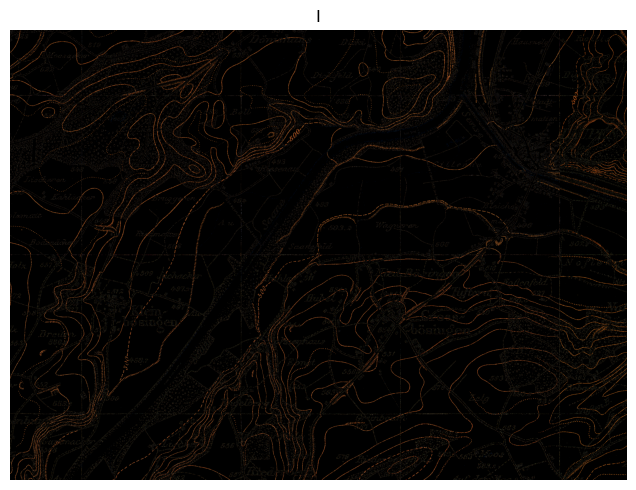

In [6]:
plot_images(image_to_process, titles="Image to process")

## Step 1 - Flood fill and morphology

Apply flood fill and morphological operations (dilation, erosion).

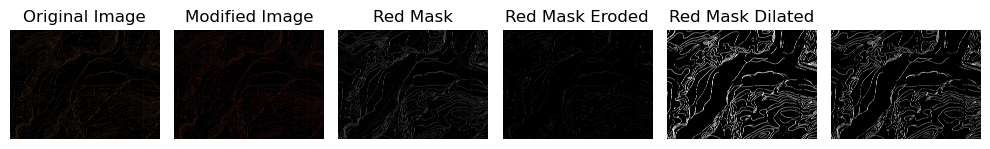

In [7]:
img_test = color.rgb2hsv(image_to_process)
img_test_copy = np.copy(img_test)
# flood function returns a mask of flooded pixels
mask = flood(img_test[..., 0], seed_point, tolerance=0.5)
# Set pixels of mask to new value for hue channel
img_test[mask, 0] = 0


# Create a mask for red hue values: low red and high red
low_red_mask = img_test[..., 2] > 0.4

# Combine both masks to capture all red pixels (low and high red hues)
red_mask = low_red_mask 

# erode
kernel = np.ones((2,2),np.uint8)
kernel2 = np.ones((5,5),np.uint8)
kernel3 = np.ones((3,3),np.uint8)
kernel4 = np.ones((7,7),np.uint8)
red_mask_eroded = cv2.erode(red_mask.astype(np.uint8), kernel, iterations=1)
red_mask_dilated = cv2.dilate(red_mask_eroded, kernel3, iterations=3)
red_mask_eroded_2 = cv2.erode(red_mask_dilated, kernel3, iterations=1)


image_test_rgb = color.hsv2rgb(img_test)

# Plot the original, modified, and red mask images
plot_images(image_to_process, image_test_rgb, red_mask, red_mask_eroded,red_mask_dilated,red_mask_eroded_2, titles=['Original Image', 'Modified Image', 'Red Mask', 'Red Mask Eroded','Red Mask Dilated'], height=10)


## Step 2 - Find conncected components

Find label connected components

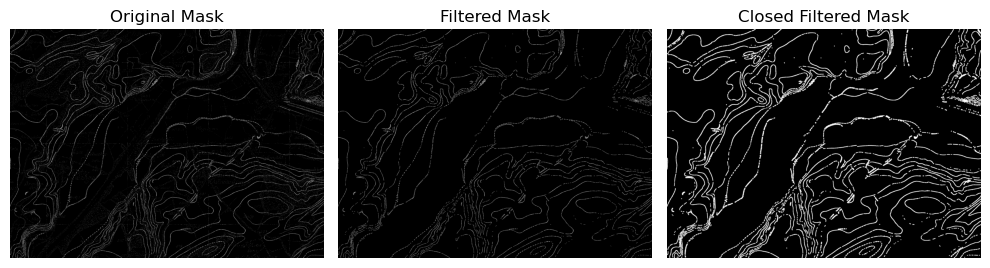

In [8]:
import cv2
import numpy as np

# Assuming your input image is a boolean mask (True/False or 0/1)
# Convert the image to uint8 format (0 or 255)
red_mask_uint8 = red_mask.astype(np.uint8) * 255

# Label connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(red_mask_uint8, connectivity=8)

# The stats output gives us the size of each component, we will filter based on size
min_size = 12  # Threshold to remove small blobs (size in pixels)

# Create a new image to store the filtered output
filtered_img = np.zeros_like(red_mask_uint8)

# Keep only components larger than min_size
for i in range(1, num_labels):  # Start from 1 to skip the background
    if stats[i, cv2.CC_STAT_AREA] >= min_size:
        filtered_img[labels == i] = 255

# Apply a morphological closing operation to fill small holes        
kernel = np.ones((5,5),np.uint8)
dilated_filtered_img = cv2.dilate(filtered_img, kernel, iterations=1)

# Show the filtered image
plot_images(red_mask_uint8, filtered_img,dilated_filtered_img, titles=['Original Mask', 'Filtered Mask','Closed Filtered Mask'], height=10)


## Step 3 - Skeletonization

Perform skeletonization to get centerlines


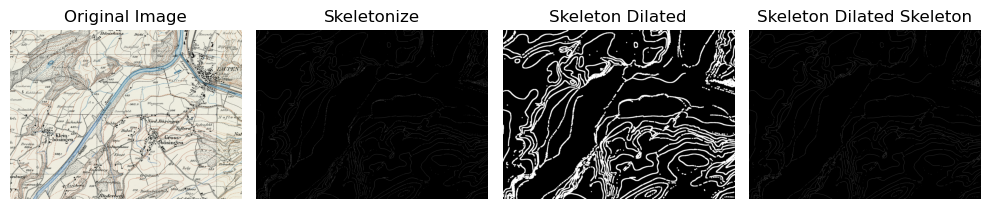

In [10]:
# Step 1: Binary mask (e.g., mask_finished from your previous operation)
# This binary mask should contain the contour shapes

# Step 2: Perform skeletonization to get the centerline of the shapes
skeleton = morphology.skeletonize(dilated_filtered_img)
skeleton_lee = morphology.skeletonize(dilated_filtered_img,method='lee')


kernel = np.ones((5,5),np.uint8)
skeleton_dilated = cv2.dilate(skeleton_lee.astype(np.uint8), kernel, iterations=3)
skeleton2 = morphology.skeletonize(skeleton_dilated)
plot_images(original_image, skeleton,skeleton_dilated, skeleton2, titles=['Original Image', 'Skeletonize', 'Skeleton Dilated','Skeleton Dilated Skeleton'], height=10)

In [180]:
# Save skeleton2 as a PNG image
if process == 'full':
    plt.imsave('output/skeleton_full_image.png', skeleton2, cmap='gray')
else:
    plt.imsave('output/skeleton_crop_image.png', skeleton2, cmap='gray')


## Step 4

Raster -> Vector

### Approach A - Contours

In [133]:
import rasterio
from rasterio.crs import CRS
from pyproj import Transformer

# Path to your TIFF file
tiff_file_path = 'data/Siegfried.tif'  # Replace with your TIFF file path

# Read the TIFF metadata
with rasterio.open(tiff_file_path) as src:
    # Get the affine transformation and CRS
    transform = src.transform  # Affine transformation of the image
    crs = src.crs  # Get the coordinate reference system (CRS)
    
    # Ensure CRS is in EPSG format and print it for verification
    print(f'Original CRS: {crs}')

    # Get the coordinate of the top-left corner
    top_left_x, top_left_y = transform * (0, 0)

# Create a transformer to convert from EPSG:21781 to EPSG:2056
transformer = Transformer.from_crs(crs, CRS.from_epsg(2056), always_xy=True)
    
print(f'Top-left corner coordinates: ({top_left_x}, {top_left_y})')

Original CRS: EPSG:21781
Top-left corner coordinates: (581549.0, 195411.0)


In [129]:
from svgwrite import Drawing
import geopandas as gpd
from shapely.geometry import LineString

# Convert back to uint8 for further OpenCV operations
skeleton_uint8 = (skeleton2 * 255).astype(np.uint8)

# Extract contours (skeleton lines)
contours, _ = cv2.findContours(skeleton_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Get the coordinates of the skeleton lines
vector_lines = [contour.reshape(-1, 2) for contour in contours]

from scipy.interpolate import splprep, splev
import numpy as np

# Create an SVG drawing
dwg = Drawing('output/output.svg', profile='tiny')

# List to hold the LineString geometries
geometries = []

# Loop over all contours in vector_lines
for contour in vector_lines:
    # Extract x and y coordinates
    x, y = contour[:, 0], contour[:, 1]
    
    # Skip if the contour has fewer than 3 points (not enough for spline fitting)
    if len(x) < 3:
        continue

    # Fit a spline to the current contour
    tck, u = splprep([x, y], s=200)
    u_fine = np.linspace(0, 1, 500)

    # Evaluate the spline
    x_fine, y_fine = splev(u_fine, tck)

    # Combine x and y into a single array of points
    smoothed_line = np.column_stack((x_fine, y_fine))
    
    # Create a smoothed line as a list of coordinate tuples
    smoothed_coords = list(zip(x_fine, y_fine))

    # Create a polyline from the smoothed coordinates and add it to the drawing
    polyline = dwg.polyline(smoothed_line.tolist(), stroke="black", fill="none")
    dwg.add(polyline)
    
    # Adjust coordinates to match the TIFF file origin
    adjusted_coords = [(x + top_left_x, top_left_y - y) for x, y in smoothed_coords]  # Note the y inversion

    
    # Convert the smoothed coordinates into a LineString geometry
    line = LineString(adjusted_coords)


    # Add the transformed LineString geometry to the list
    geometries.append(line)

# Save the drawing
dwg.save()


# Create a GeoDataFrame from the geometries
gdf = gpd.GeoDataFrame(geometry=geometries)

# Set the CRS to EPSG:2056 (Swiss coordinate system)
gdf.set_crs(epsg=21781, inplace=True)


# Export to GeoJSON
gdf.to_file("output/output.geojson", driver="GeoJSON")

### Approach B - Find Points

In [19]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize
from itertools import combinations

In [75]:


def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

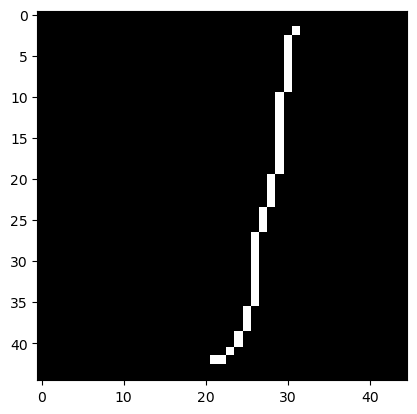

In [76]:
"""img_bgr = cv2.imread('lines.png',1)
img = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2GRAY)

_,img = cv2.threshold(img,10,1,cv2.THRESH_BINARY_INV)

skeleton = skeletonize(img,method='lee')
"""

skeleton_bgr = cv2.cvtColor(skeleton2.astype(np.uint8),cv2.COLOR_GRAY2BGR)


fig,ax = plt.subplots(1)
ax.imshow(skeleton, cmap = 'gray')

[[31  5]
 [22 39]]


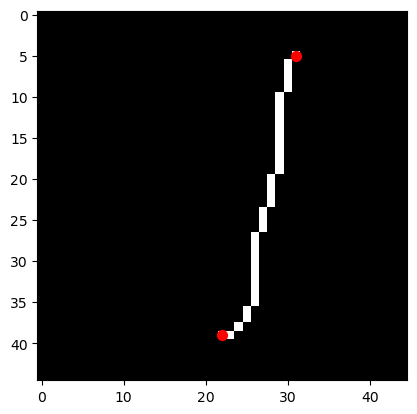

In [114]:
# Get tips as before
img_conv = cv2.filter2D(skeleton2.astype(np.uint8), -1, np.ones((3,3))) #
img_conv = img_conv * skeleton2
img_tips = img_conv == 2
tips = np.array(np.nonzero(img_tips)).T

# Swap the columns (y, x) -> (x, y)
tips = tips[:, [1, 0]]  # Swap columns

print(tips)  # This will now print [[31 5], [22 39]]

# Plot the image and tips
fig, ax = plt.subplots(1)
ax.imshow(skeleton2, cmap='gray')
ax.scatter(tips[:, 0], tips[:, 1], s=50, color='r')  # Plot swapped coordinates


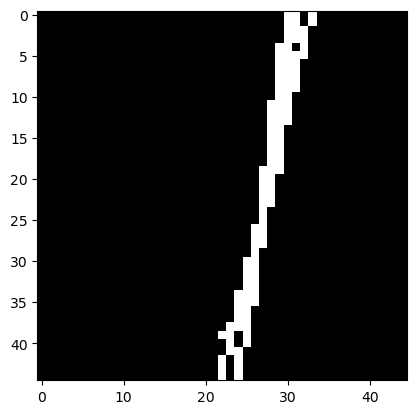

In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Ensure the image is binary (0 or 255)
skeleton2_binary = (skeleton2 > 0).astype(np.uint8) * 255  # Convert to binary if needed

# Apply HoughLines with a lower threshold
lines = cv2.HoughLines(skeleton2_binary, 1, np.pi / 180, 15)  # Lower threshold

# Check if lines were detected
if lines is not None:
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(skeleton2_binary, (x1, y1), (x2, y2), (255, 0, 0), 1)
    
    # Plot the image with detected lines
    plt.imshow(skeleton2_binary, cmap='gray')
    plt.show()
else:
    print("No lines detected.")


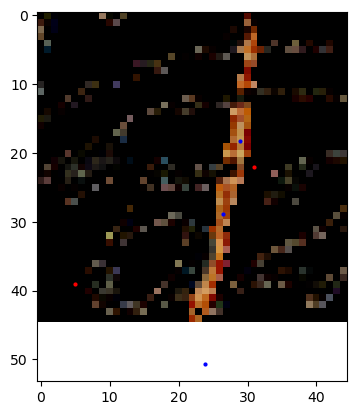

In [121]:


lines_points = []

# # Draw the lines
for i in range(0, len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(skeleton_bgr, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)
    lines_points.append([pt1,pt2])


line_combinations = combinations(lines_points, 2)



fig,ax = plt.subplots(1)
ax.imshow(image_to_process, cmap = 'gray')
ax.scatter(tips[0,:],tips[1,:],s=4,color='r')

for line_combination in list(line_combinations):
    line1 = line_combination[0]
    line2 = line_combination[1]

    intersection = line_intersection(line1,line2)
    
    # clip the intersection points to the image size    
    if intersection[0]<image_rgb.shape[1] and intersection[1]<image_rgb.shape[0]:
        ax.scatter(intersection[0],intersection[1],s=4,color='b')

# fig,ax = plt.subplots(1)
# ax.imshow(skeleton_bgr,'gray')

plt.show()

### Approach C - Skeleton Tracing

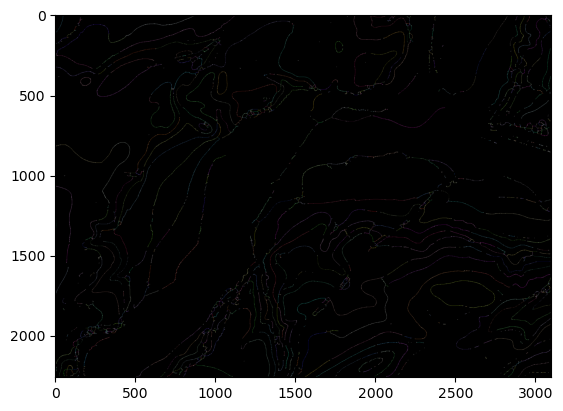

In [11]:
from trace_skeleton import *
import cv2
import random

if process == 'full':
    im0 = cv2.imread("output/skeleton_full_image.png")
else:
    im0 = cv2.imread("output/skeleton_crop_image.png")
im = (im0[:,:,0]>128).astype(np.uint8)


im = thinning(im)

rects = []
polys = traceSkeleton(im,0,0,im.shape[1],im.shape[0],10,999,rects)

for l in polys:
  c = (200*random.random(),200*random.random(),200*random.random())
  for i in range(0,len(l)-1):
    cv2.line(im0,(l[i][0],l[i][1]),(l[i+1][0],l[i+1][1]),c)

plt.imshow(im0)


GeoJSON saved as output/skeleton_lines_full_image_2.geojson


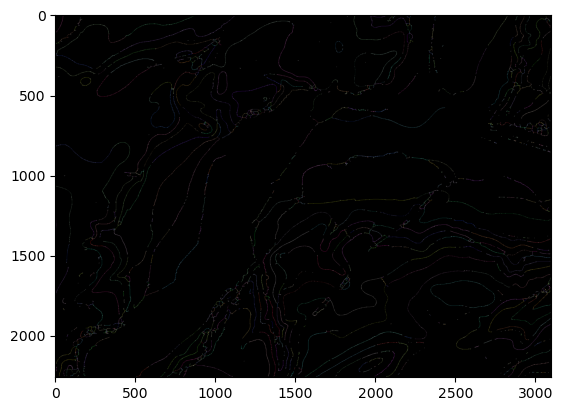

In [6]:
import json
import random
import cv2
import matplotlib.pyplot as plt
import rasterio
from trace_skeleton import thinning, traceSkeleton

# Path to your original TIFF file (the one used for the skeleton image)
tiff_file_path = 'data/Siegfried.tif'

# Read the pixel size (resolution) from the TIFF file using rasterio
with rasterio.open(tiff_file_path) as src:
    transform = src.transform
    pixel_width = transform[0]  # Size of a pixel in the x direction (in meters)
    pixel_height = abs(transform[4])  # Size of a pixel in the y direction (in meters)

# Constants to convert image coordinates to EPSG:2056
LON_CONSTANT = 581549  # Adjust to the correct EPSG:2056 longitude base
LAT_CONSTANT = 192585.0  # Adjust to the correct EPSG:2056 latitude base

# Load skeleton image
if process == 'full':
    im0 = cv2.imread("output/skeleton_full_image.png")
else:
    im0 = cv2.imread("output/skeleton_crop_image.png")

# Binarize the skeleton image
im = (im0[:,:,0] > 128).astype(np.uint8)

# Get image dimensions
height, width = im.shape

# Thin the image
im = thinning(im)

# Trace the skeleton to get line coordinates
rects = []
polys = traceSkeleton(im, 0, 0, width, height, 10, 500, rects)

# Convert image coordinates to EPSG:2056 and store in GeoJSON format
features = []
for l in polys:
    coordinates = []
    for coord in l:
        # Flip Y axis by subtracting the pixel's y-coordinate from the image height
        flipped_y = height - coord[1]

        # Apply pixel size to convert image coordinates to real-world distances
        scaled_x = coord[0] * pixel_width  # Apply pixel width scaling
        scaled_y = flipped_y * pixel_height  # Apply pixel height scaling
        
        # Convert image coordinates to EPSG:2056 by adding the constants
        lon = scaled_x + LON_CONSTANT  # X-axis (longitude/easting)
        lat = scaled_y + LAT_CONSTANT  # Y-axis (latitude/northing)

        coordinates.append([lon, lat])

    # Create a GeoJSON feature for each line
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": coordinates
        },
        "properties": {
            "color": f"rgb({200*random.random()}, {200*random.random()}, {200*random.random()})"
        }
    }
    features.append(feature)

# Create GeoJSON structure
geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

# Save the GeoJSON to a file
if process == 'full':
    geojson_path = 'output/skeleton_lines_full_image_2.geojson'
else:
    geojson_path = 'output/skeleton_lines_crop_imag_2.geojson'

with open(geojson_path, 'w') as geojson_file:
    json.dump(geojson_data, geojson_file, indent=2)

print(f"GeoJSON saved as {geojson_path}")

# Optionally, display the image with colored lines
for l in polys:
    c = (200*random.random(), 200*random.random(), 200*random.random())
    for i in range(0, len(l) - 1):
        cv2.line(im0, (l[i][0], l[i][1]), (l[i+1][0], l[i+1][1]), c)

plt.imshow(im0)
plt.show()


## Step 5

Removing doubled lines

In [7]:
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np

def calculate_angle(v1, v2):
    """Calculate the angle in degrees between two vectors."""
    v1_norm = np.linalg.norm(v1)
    v2_norm = np.linalg.norm(v2)
    if v1_norm == 0 or v2_norm == 0:
        return 0
    cos_angle = np.dot(v1, v2) / (v1_norm * v2_norm)
    # Clamp the value to avoid numerical issues
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle = np.arccos(cos_angle)
    return np.degrees(angle)

def split_linestring(linestring):
    points = list(linestring.coords)
    segments = []
    
    # If the LineString has less than 5 points, return it as is
    if len(points) < 5:
        return [linestring]
    
    current_segment = [points[0]]

    for i in range(4, len(points)):  # Start from p-4 (index 4)
        p4 = np.array(points[i - 4])
        p3 = np.array(points[i - 3])
        p2 = np.array(points[i - 2])
        p1 = np.array(points[i - 1])
        p0 = np.array(points[i])

        # Calculate direction vectors
        v1 = p3 - p4  # Vector from p-4 to p-3
        v2 = p1 - p0  # Vector from p-1 to p

        # Calculate the angle between the two vectors
        angle = calculate_angle(v1, v2)

        # Check if there's a direction change
        if angle > 170:  # or a threshold of your choice
            # Append the current segment if it has more than one point
            if len(current_segment) > 1:
                try:
                    segments.append(LineString(current_segment))
                except Exception as e:
                    print(f"Error creating LineString: {e}")
            current_segment = [points[i]]  # Start a new segment

        current_segment.append(points[i])

    # Append the last segment if it has more than one point
    if len(current_segment) > 1:
        try:
            segments.append(LineString(current_segment))
        except Exception as e:
            print(f"Error creating LineString: {e}")
    
    return segments

def process_contour_lines(gdf):
    unique_lines = []
    
    for idx, row in gdf.iterrows():
        linestring = row.geometry
        segments = split_linestring(linestring)
        
        for seg in segments:
            if seg not in unique_lines:
                unique_lines.append(seg)

    # Create a new GeoDataFrame with unique lines
    new_gdf = gpd.GeoDataFrame(geometry=unique_lines, crs=gdf.crs)
    return new_gdf



In [8]:
# Load the GeoJSON file
gdf = gpd.read_file("output/output.geojson")

# Process the contour lines
cleaned_gdf = process_contour_lines(gdf)

# Save the cleaned GeoJSON
cleaned_gdf.to_file("output/cleaned_contour_lines.geojson", driver='GeoJSON')


KeyboardInterrupt: 